In [3]:
# Importerer pakker:
from extendedmodel import *
from utils import *
from pancreas import *
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint

Initializes patients, and meals. Finds optimal bolus for each meal.

# Simulation

In [6]:
t = 1
pHM0 = baseline_patient(0, model = "HM", timestep=t, n_pancreas = 20)
pHM1 = baseline_patient(1, model = "HM", timestep=t)
pHM2 = baseline_patient(2, model = "HM", timestep=t, n_pancreas = 20)

meals1 = np.array([[50, 6,6.25], [20, 10, 10.25], [100, 12.5, 12.75], [20, 15, 15.25], [100, 18.5, 18.75], [20, 21, 21.25]])
meals2 = np.array([[100, 6,6.25], [100, 12.5, 12.75], [100, 18.5, 18.75]])
meals3 = np.array([[50, 7.5,7.75], [20, 10, 10.25], [20, 15, 15.25], [70, 18.5, 18.75], [20, 21, 21.25]])
meals4 = np.array([[50, 6,6.25], [20, 10, 10.25], [20, 15, 15.25], [70, 18.5, 18.75], [20, 21, 21.25]])
meals5 = np.array([[20, 9, 9.25], [20, 10, 10.25], [40, 15, 15.25], [100, 18.5, 18.75], [70, 21, 21.25]])
pid_keys =  ["Kp", "Ti", "Td"]
params = [0.5, 500, 25]

meals = [meals1]
res0 = []
res1 = []
res2 = []
for i,m in enumerate(meals):
    for i,k in enumerate(pid_keys):
        setattr(pHM1.pumpObj, k, params[i])
        setattr(pHM2.pumpObj, k, params[i])
    res1.append(plan_treatment(pHM1, m))
    res2.append(plan_treatment(pHM2, m))

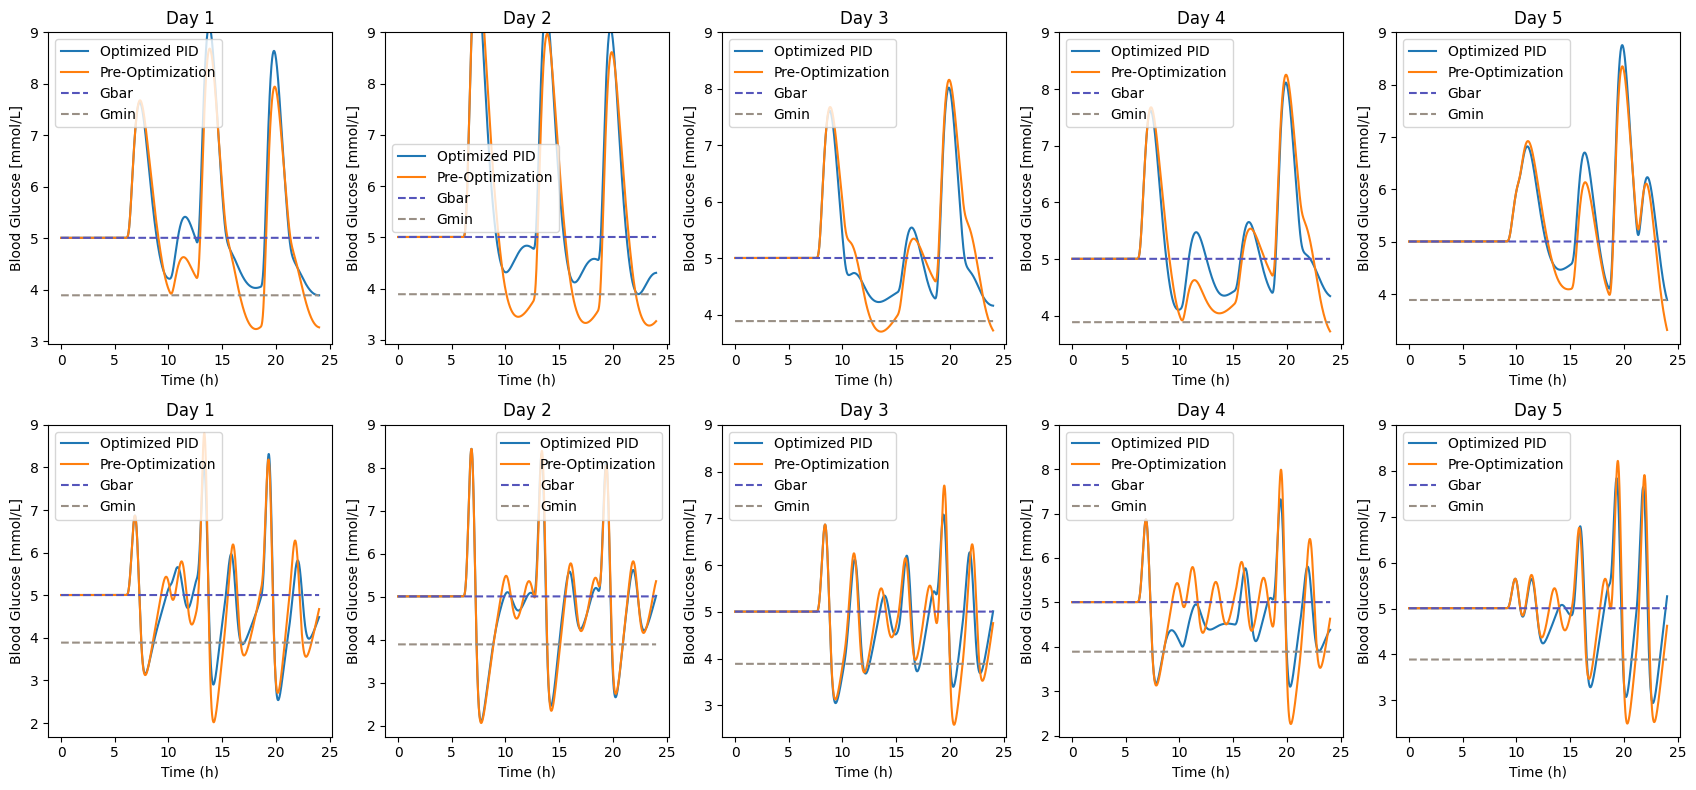

In [10]:
n_patients = 2
fig, ax = plt.subplots(n_patients, len(meals), figsize=(17, 8))
r = [res1, res2]
for i in range(len(meals)):
    for k in range(n_patients):        
        bolus, info, info_opt, opt = r[k][i]
        j = i * n_patients + k
        ax[k,i].plot(info_opt["t"]/60, info_opt["G"], label="Optimized PID")
        ax[k,i].plot(info["t"]/60, info["G"], label="Pre-Optimization")
        ax[k,i].set_title(f"Day {i+1}")
        ax[k,i].set_xlabel("Time (h)")
        ax[k,i].set_ylabel("Blood Glucose [mmol/L]")
        ax[k, i].set_ylim(top=9)
        ax[k, i].plot(info["t"]/60,np.ones(len(info["t"]))*info["G"][0], "--",color="#5555BB", label= "Gbar")
        ax[k, i].plot(info["t"]/60,np.ones(len(info["t"]))*3.889, "--",color="#998F85", label= "Gmin")
        ax[k,i].legend()

fig.tight_layout()
plt.show()

In [2]:

meals = np.array([[50, 6,6.25], [20, 10, 10.25], [100, 12.5, 12.75], [20, 15, 15.25], [100, 18.5, 18.75], [20, 21, 21.25]])
meal_arr = timestamp_arr(meals, t, fill = 0)

bolus1 = []
bolus2 = []
for m in meals:
    u1, phi, p, Gt = p_EHMT1.meal_bolus(m[0], max_U = 5000, n = 100)
    u2, phi, p, Gt = p_EHMT2.meal_bolus(m[0], max_U = 500, n = 100)

    bolus1.append([u1,m[1]])
    bolus2.append([u2,m[1]])

bolus1 = np.array(bolus1)
bolus2 = np.array(bolus2)


In [3]:
bolus1_arr = timestamp_arr(bolus1, t, fill = None)
bolus2_arr = timestamp_arr(bolus2, t, fill = None)

info0 = p_EHM0.simulate(ds = meal_arr)
info1 = p_EHMT1.simulate(ds = meal_arr, uIs = bolus1_arr)
info2 = p_EHMT2.simulate(ds = meal_arr, uIs = bolus2_arr)

filter_u(info1)
filter_u(info2)

bolus = np.vstack([bolus1[:,0],bolus2[:,1]])
print(generate_table(meals, bolus))


[[1969.6969697   707.07070707 3030.3030303   707.07070707 3030.3030303
   707.07070707]
 [   6.           10.           12.5          15.           18.5
    21.        ]]
\begin{table}[]
\begin{tabular}{|r|r|r|r|}\hline 
Time & Meal & Bolus Size \\ \hline 
06:00-06:15 & 50 & 1969 & 6 \\ \hline 
10:00-10:15 & 20 & 707 & 10 \\ \hline 
12:30-12:45 & 100 & 3030 & 12 \\ \hline 
15:00-15:15 & 20 & 707 & 15 \\ \hline 
18:30-18:45 & 100 & 3030 & 18 \\ \hline 
21:00-21:15 & 20 & 707 & 21 \\ \hline 
\end{tabular}
\end{table}


In [4]:
opt1 = optimize_pid(p_EHMT1, meal_arr, bolus1_arr)
opt2 = optimize_pid(p_EHMT2, meal_arr, bolus2_arr)

In [6]:
info1_opt = p_EHMT1.simulate(ds = meal_arr, uIs = bolus1_arr)
info2_opt = p_EHMT2.simulate(ds = meal_arr, uIs = bolus2_arr)


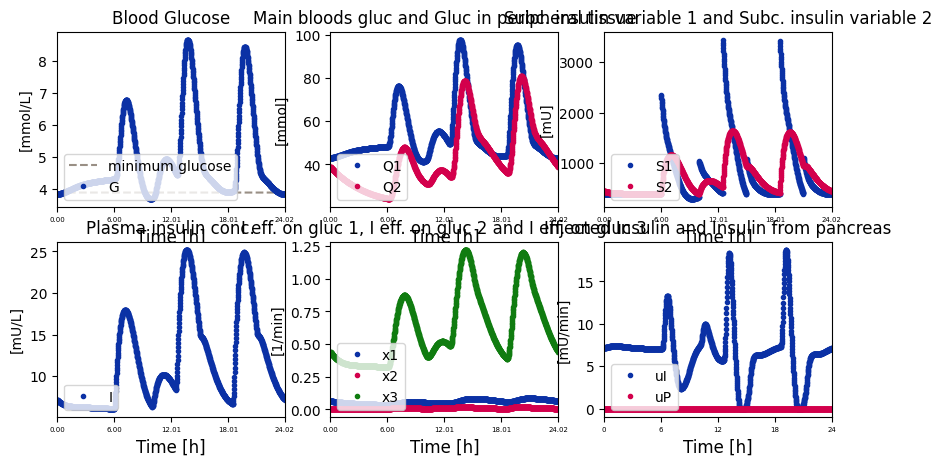

In [8]:
filter_u(info1_opt)
filter_u(info2_opt)

p_EHMT1.statePlot(info1_opt, (2,3), (10, 5), [["G"],["Q1", "Q2"], ["S1", "S2"], ["I"], ["x1", "x2", "x3"], ["uI", "uP"]], 12)

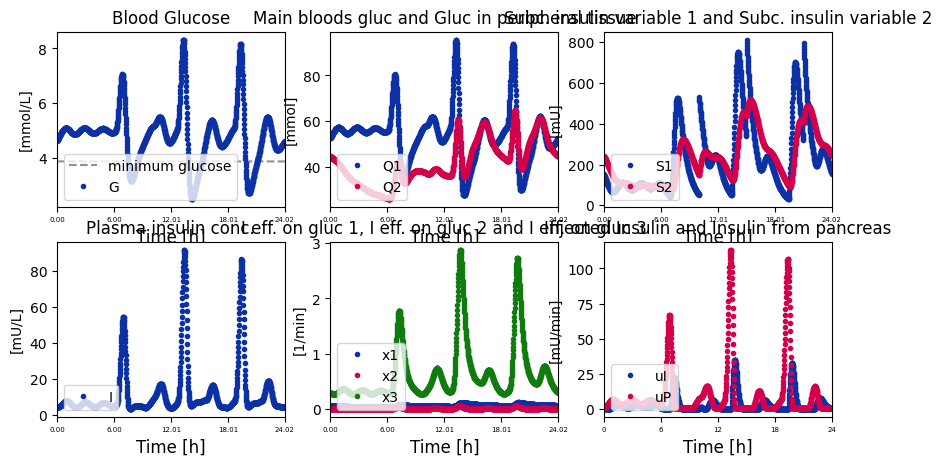

In [9]:
p_EHMT2.statePlot(info2_opt, (2,3), (10, 5), [["G"],["Q1", "Q2"], ["S1", "S2"], ["I"], ["x1", "x2", "x3"], ["uI", "uP"]], 12)

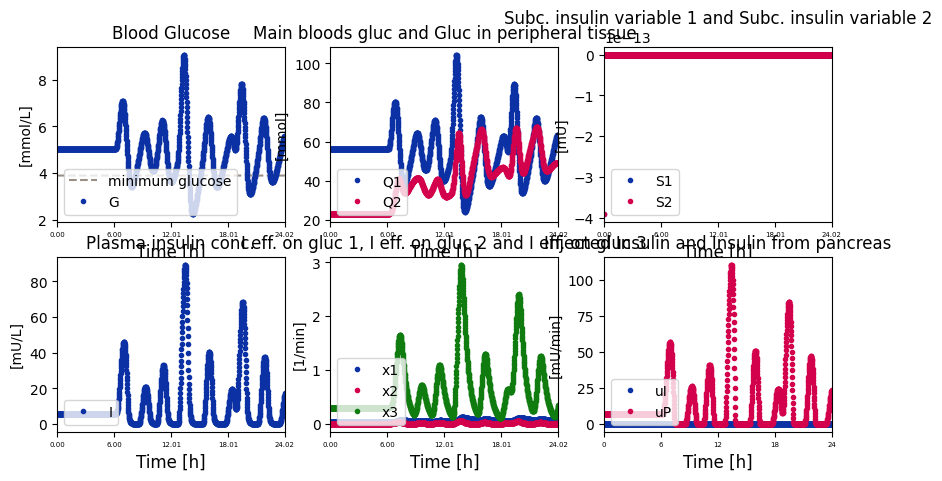

In [18]:
p_EHM0.statePlot(info0, (2,3), (10, 5), [["G"],["Q1", "Q2"], ["S1", "S2"], ["I"], ["x1", "x2", "x3"], ["uI", "uP"]], 12)

In [27]:
print("Penalty")
def format_e(n):
    a = '%E' % n
    return a.split('E')[0].rstrip('0').rstrip('.') + 'E' + a.split('E')[1]

print(info0["pens"].sum())
print(info1["pens"].sum())
print(info1_opt["pens"].sum())
print(info2["pens"].sum())
print(info2_opt["pens"].sum())

Penalty
201039185782.70746
20085306881.491295
2679744362.2140746
355822259741.98004
207929570457.18878


# Optimal Bolus

In [1]:
# Importerer pakker:
from extendedmodel import *
from utils import *
from pancreas import *
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint

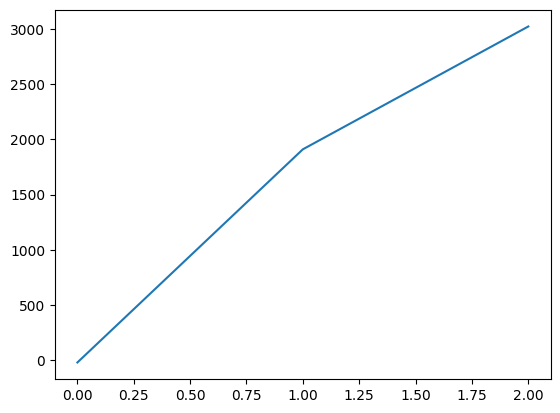

In [58]:
t = 1
from scipy.optimize import minimize_scalar
p = baseline_patient(1, model = "HM", timestep=t)
def best_bolus(patient, meal_size, meal_idx = 0, iterations = None):
    if iterations == None:
        iterations = int(24 * 60 / patient.timestep)
    def cost(u):
        phi, _, _ = patient.bolus_sim(u, meal_size, meal_idx, iterations)
        return phi
    return minimize_scalar(cost, tol=1e-10)
pat = baseline_patient(1, model = "HM", timestep=t)

phis = []
def best_bolus(patient, meal_size, h = 24, max_bolus = 10000, splits = 10):
    if isinstance(meal_size, (np.ndarray, list)):
        return np.array([best_bolus(patient, meal_size=m, h = h) for m in meal_size])
    # broad and rough search for minima
    iterations = int(h * 60 / patient.timestep)
    us = np.linspace(0, max_bolus, splits)
    phis = []
    for u in us:
        phi, _, _ = patient.bolus_sim(u, meal_size = meal_size, iterations = iterations)
        phis.append(phi)
    u0 = us[np.argmin(phis)]
    def cost(u):
        phi, _, _ = patient.bolus_sim(u, meal_size = meal_size, iterations = iterations)
        return phi
    return minimize_scalar(cost, bounds=[u0 - max_bolus/splits, u0 + max_bolus/splits]).x

u = best_bolus(pat, np.arange(0, 150, 50))
plt.plot(u)
#phi, p, Gt = pat.bolus_sim(res, 40, iterations = int(24 * 60 / pat.timestep))
#print(phi)
#plt.plot(Gt)
#plt.semilogy(us, phis)


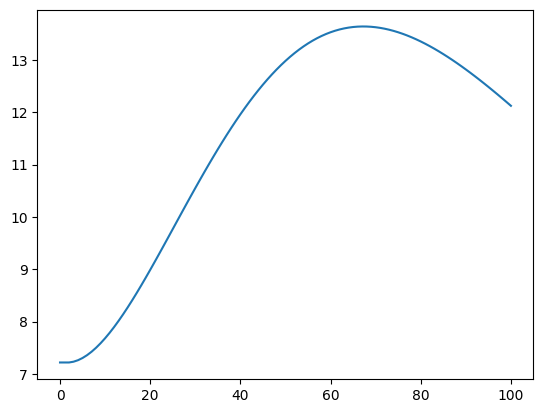

In [105]:
patmvp = baseline_patient(1, model = "MVP", timestep=t)
phi, p, G = patmvp.bolus_sim(10000, 150)
plt.plot(G)

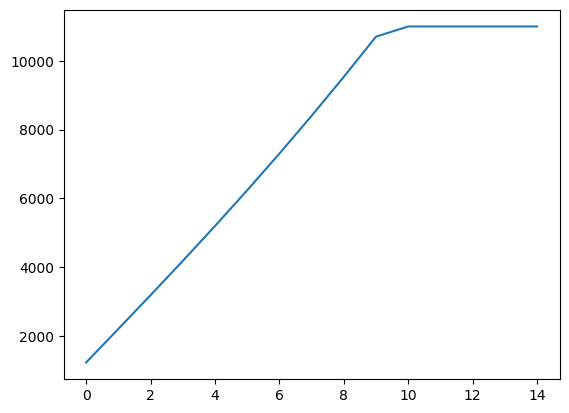

In [107]:
patmvp = baseline_patient(1, model = "MVP", timestep=t)
u = best_bolus(patmvp, np.arange(0, 150, 10))
plt.plot(u)

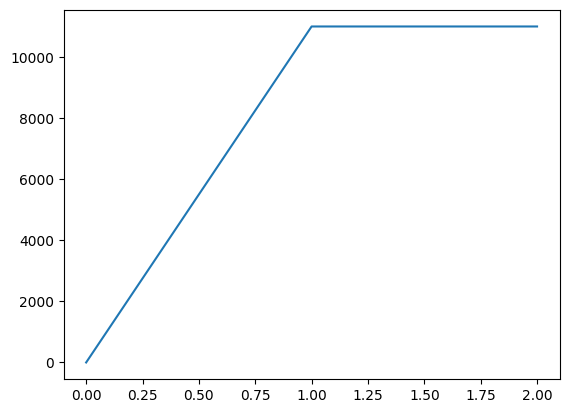

In [61]:
patmvp = baseline_patient(1, model = "MVP", timestep=t)
umvp = best_bolus(patmvp, np.arange(0,150,50), max_bolus = 8*10000)
plt.plot(umvp)

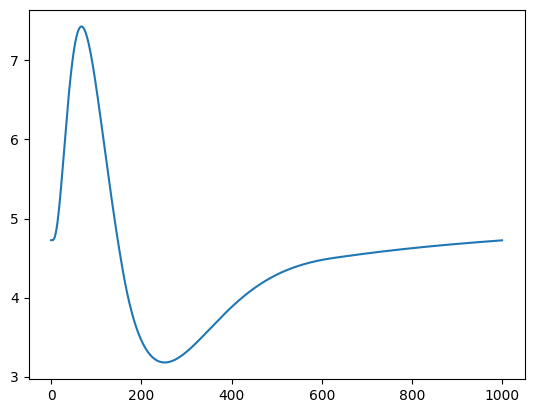

In [16]:
plt.plot(Gt)